In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip cache purge
!pip install --timeout=100 qiskit==1.4.3
!pip install --timeout=100 qiskit-aer==0.14.2
!pip install --timeout=100 qiskit-ibm-runtime==0.23.0
!pip install --timeout=100 qiskit-machine-learning==0.7.2
!pip install --timeout=100 qiskit-algorithms==0.3.0
!pip install --timeout=100 qiskit-aer-gpu==0.14.2
!pip install --timeout=100 scikit-learn
!pip install --timeout=100 imbalanced-learn
!pip install --timeout=100 matplotlib

Files removed: 0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.8/366.8 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 17.7 MB/s eta 0:0

In [ ]:
%env IBM_CLOUD_API_KEY=your_real_key_here
%env IBM_QUANTUM_CRN=your_crn_here

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, RealAmplitudes, EfficientSU2,TwoLocal
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
file_path = '/content/drive/My Drive/Parkinson\'s Disease ClassificationModel/Dataset/pd_speech_features.csv'

# load data
data = pd.read_csv(file_path, skiprows=1)
print(data.shape)
print(data.head())

X = data.drop(['id', 'class'], axis=1)
y = data['class'].values

# normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")

(756, 755)
   id  gender      PPE      DFA     RPDE  numPulses  numPeriodsPulses  \
0   0       1  0.85247  0.71826  0.57227        240               239   
1   0       1  0.76686  0.69481  0.53966        234               233   
2   0       1  0.85083  0.67604  0.58982        232               231   
3   1       0  0.41121  0.79672  0.59257        178               177   
4   1       0  0.32790  0.79782  0.53028        236               235   

   meanPeriodPulses  stdDevPeriodPulses  locPctJitter  ...  \
0          0.008064            0.000087       0.00218  ...   
1          0.008258            0.000073       0.00195  ...   
2          0.008340            0.000060       0.00176  ...   
3          0.010858            0.000183       0.00419  ...   
4          0.008162            0.002669       0.00535  ...   

   tqwt_kurtosisValue_dec_28  tqwt_kurtosisValue_dec_29  \
0                     1.5620                     2.6445   
1                     1.5589                     3.6107   


In [ ]:
# IBM quantum runtime service
service = QiskitRuntimeService(
    channel="ibm_cloud",
    token=os.getenv("IBM_CLOUD_API_KEY"),
    instance=os.getenv("IBM_QUANTUM_CRN")
)
print(service.backends())

[<IBMBackend('ibm_pittsburgh')>, <IBMBackend('ibm_kingston')>, <IBMBackend('ibm_fez')>, <IBMBackend('ibm_marrakesh')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_brisbane')>]


In [ ]:
backend = service.least_busy(operational=True, simulator=False)
print("Using backend:", backend)

Using backend: <IBMBackend('ibm_kingston')>


In [ ]:
def train_vqc(num_qubits, feature_map_type, ansatz_type, reps, optimizer_type):
    pca = PCA(n_components=num_qubits)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)

    if feature_map_type == 'ZZ':
        feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear')
    elif feature_map_type == 'Z':
        feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)

    # ansatz
    if ansatz_type == 'RealAmplitudes':
        ansatz = RealAmplitudes(num_qubits=num_qubits, reps=reps)
    elif ansatz_type == 'EfficientSU2':
        ansatz = EfficientSU2(num_qubits=num_qubits, reps=reps)
    elif ansatz_type == 'TwoLocal_full':
        ansatz = TwoLocal(
            num_qubits,
            rotation_blocks=['ry'],
            entanglement_blocks='cx',
            entanglement='full',
            reps=reps
        )

    #optimizer
    if optimizer_type == 'COBYLA':
        optimizer = COBYLA(maxiter=100)
    elif optimizer_type == 'SPSA':
        optimizer = SPSA(maxiter=100)

    # IBM Quantum backend
    backend = service.least_busy(operational=True, simulator=False)
    print(f"\n[INFO] Using backend: {backend.name}")
    sampler = SamplerV2(backend=backend)

    # combine feature map and ansatz
    circuit = feature_map.compose(ansatz)

    # VQC setup with custom sampling
    global objective_func_vals
    objective_func_vals = []

    vqc = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph
    )

    job_ids = []

    def custom_sampler(data, weights):
        bound_circuits = [
            circuit.bind_parameters({
                **dict(zip(feature_map.parameters, x)),
                **dict(zip(ansatz.parameters, weights))
            }) for x in data
        ]
        job = sampler.run(bound_circuits)
        job_ids.append(job.job_id())
        print(f"[INFO] Submitted job with ID: {job.job_id()}")
        result = job.result()
        quasi_dists = [res.data.meas.get_counts() for res in result.quasi_dists]
        return np.array([list(d.values()) for d in quasi_dists])

    vqc._sampler = lambda x, w: custom_sampler(x, w)

    #train
    vqc.fit(X_train_pca, y_train)

    #predict on validation
    y_pred = vqc.predict(X_val_pca)
    acc = accuracy_score(y_val, y_pred)

    #metrics
    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    # circuit metrics
    qc = feature_map.compose(ansatz).decompose()
    num_params = ansatz.num_parameters
    depth = qc.depth()
    qubits = qc.num_qubits

    # print summary
    print(f"Config: Qubits={num_qubits}, FM={feature_map_type}, Ansatz={ansatz_type}, Reps={reps}, Opt={optimizer_type}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Parameters: {num_params}, Depth: {depth}, Qubits: {qubits}")

    return vqc, acc, precision, recall, f1, num_params, depth, qubits, pca, backend.name, job_ids


In [ ]:
configs = [
    (2, 'Z', 'RealAmplitudes', 3, 'SPSA'),
    (4, 'Z', 'RealAmplitudes', 3, 'SPSA'),
    (6, 'Z', 'RealAmplitudes', 3, 'SPSA'),
    (8, 'Z', 'RealAmplitudes', 3, 'SPSA'),
    (10, 'Z', 'RealAmplitudes', 3, 'SPSA'),
    (12, 'Z', 'RealAmplitudes', 3, 'SPSA'),
    (14, 'Z', 'RealAmplitudes', 3, 'SPSA'),
]

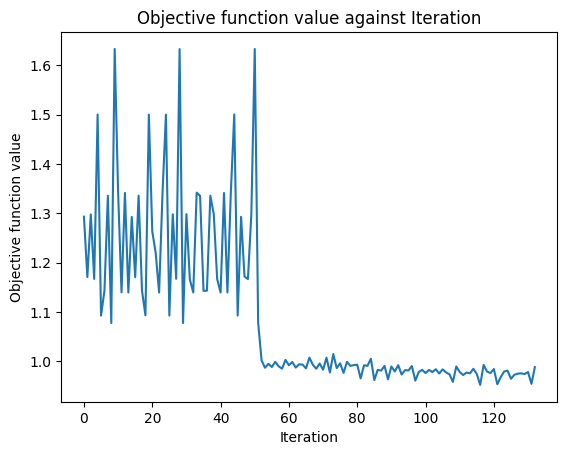

In [ ]:
# Store results
results = {
    "qubits": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "backend": [],
    "jobs": [],
    "objective": []  # store convergence per model
}

best_model = None
best_acc = 0
best_metrics = None
best_pca = None
best_backend = None
best_jobs = None


for config in configs:
    num_qubits, fm, ansatz, reps, opt = config
    print("\n" + "="*70)
    print(f"Running config: Qubits={num_qubits}, FM={fm}, Ansatz={ansatz}, Reps={reps}, Opt={opt}")

    model, acc, precision, recall, f1, params, depth, qubits, pca, backend_name, job_ids = train_vqc(*config)

    results["qubits"].append(num_qubits)
    results["accuracy"].append(acc)
    results["precision"].append(precision)
    results["recall"].append(recall)
    results["f1"].append(f1)
    results["backend"].append(backend_name)
    results["jobs"].append(job_ids)
    results["objective"].append(objective_func_vals.copy() if "objective_func_vals" in globals() else [])

    print("\n[MODEL SUMMARY]")
    print(f"Qubits     : {num_qubits}")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Precision  : {precision:.4f}")
    print(f"Recall     : {recall:.4f}")
    print(f"F1 Score   : {f1:.4f}")
    print(f"Parameters : {params}")
    print(f"Depth      : {depth}")
    print(f"Backend    : {backend_name}")
    print(f"Job IDs    : {job_ids}")
    print("="*70)

    # plot objective function for this run
    if len(objective_func_vals) > 0:
        plt.figure(figsize=(7,5))
        plt.plot(range(len(objective_func_vals)), objective_func_vals, marker='o')
        plt.xlabel("Iteration")
        plt.ylabel("Objective Function Value")
        plt.title(f"Training Convergence (Qubits={num_qubits}, Ansatz={ansatz})")
        plt.grid(True)
        plt.show()

    # Track best model
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_metrics = (params, depth, qubits)
        best_pca = pca
        best_backend = backend_name
        best_jobs = job_ids

print("\n" + "#"*70)
print("=============== BEST MODEL ===============")
print(f"Best Model Accuracy : {best_acc:.4f}")
print(f"Best Metrics        : Parameters={best_metrics[0]}, Depth={best_metrics[1]}, Qubits={best_metrics[2]}")
print(f"Backend             : {best_backend}")
print(f"Job IDs             : {best_jobs}")
print("#"*70)

plt.figure(figsize=(8,6))
plt.plot(results["qubits"], results["accuracy"], marker='o', label="Accuracy")
plt.plot(results["qubits"], results["precision"], marker='o', label="Precision")
plt.plot(results["qubits"], results["recall"], marker='o', label="Recall")
plt.plot(results["qubits"], results["f1"], marker='o', label="F1 Score")

plt.xlabel("Number of Qubits")
plt.ylabel("Score")
plt.title("Effect of Number of Qubits on VQC Performance (IBM Hardware)")
plt.legend()
plt.grid(True)
plt.show()


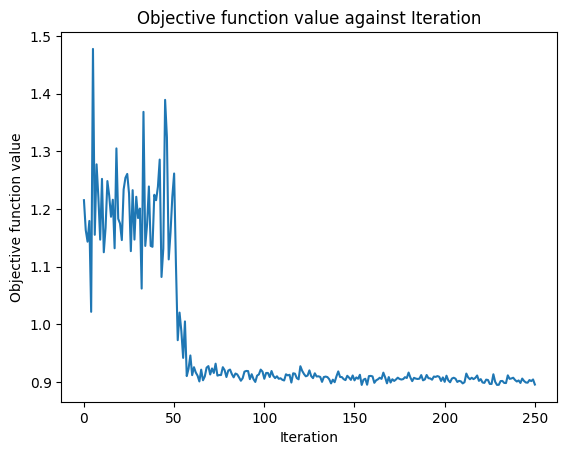

Config: Qubits=4, FM=Z, Ansatz=RealAmplitudes, Reps=3, Opt=SPSA
Accuracy: 0.6579
Parameters: 16, Depth: 15, Qubits: 4
Best Model Accuracy: 0.6579
Best Metrics: Parameters=16, Depth=15, Qubits=4


In [ ]:
best_model = None
best_acc = 0
best_metrics = None
best_pca = None

for config in configs:
    model, acc, params, depth, qubits, pca = train_vqc(*config)
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_metrics = (params, depth, qubits)
        best_pca = pca

print(f"Best Model Accuracy: {best_acc:.4f}")
print(f"Best Metrics: Parameters={best_metrics[0]}, Depth={best_metrics[1]}, Qubits={best_metrics[2]}")

In [ ]:
# experiment
configs = [
    #(8, 'ZZ', 'RealAmplitudes', 10, 'SPSA'),
    #(8, 'Z', 'EfficientSU2', 10, 'COBYLA'),
    #(4, 'ZZ', 'RealAmplitudes', 10, 'SPSA'),
    (4, 'Z', 'RealAmplitudes', 10, 'SPSA'),
    #(4, 'ZZ', 'EfficientSU2', 10, 'COBYLA'),
    #(6, 'ZZ', 'RealAmplitudes', 10, 'SPSA'),
    #(6, 'Z', 'EfficientSU2', 10, 'COBYLA'),
]

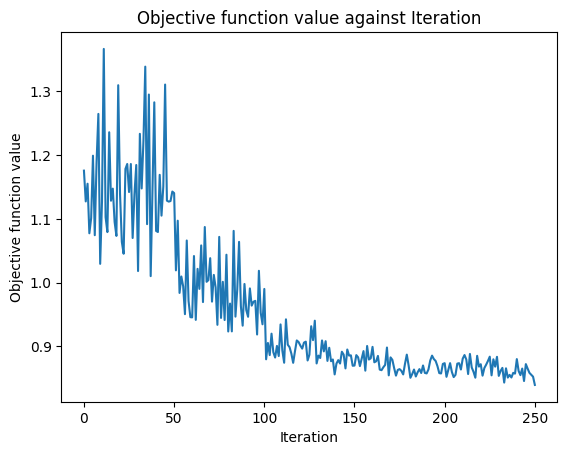

Config: Qubits=4, FM=Z, Ansatz=RealAmplitudes, Reps=10, Opt=SPSA
Accuracy: 0.7039
Parameters: 44, Depth: 36, Qubits: 4
Best Model Accuracy: 0.7039
Best Metrics: Parameters=44, Depth=36, Qubits=4


In [ ]:
best_model = None
best_acc = 0
best_metrics = None
best_pca = None

for config in configs:
    model, acc, params, depth, qubits, pca = train_vqc(*config)
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_metrics = (params, depth, qubits)
        best_pca = pca

print(f"Best Model Accuracy: {best_acc:.4f}")
print(f"Best Metrics: Parameters={best_metrics[0]}, Depth={best_metrics[1]}, Qubits={best_metrics[2]}")